In [2]:
import os
os.listdir('fish_screenshots_test/')

['screenshots0000_3178',
 'screenshots0000_3179',
 'screenshots0000_3180',
 'screenshots0000_3181',
 'screenshots0000_3182',
 'screenshots0000_3183',
 'screenshots0000_3184',
 'screenshots0000_3185',
 'screenshots0000_3186']

In [3]:
os.getcwd()

'C:\\Users\\user'

In [4]:
import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse

# Root directory for dataset
dataroot = "fish_screenshots_test/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector
nz = 100

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  1141


In [6]:
train_ds = ImageFolder(
    root=dataroot,
    transform = transforms.Compose([transforms.Resize([image_size,image_size]),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

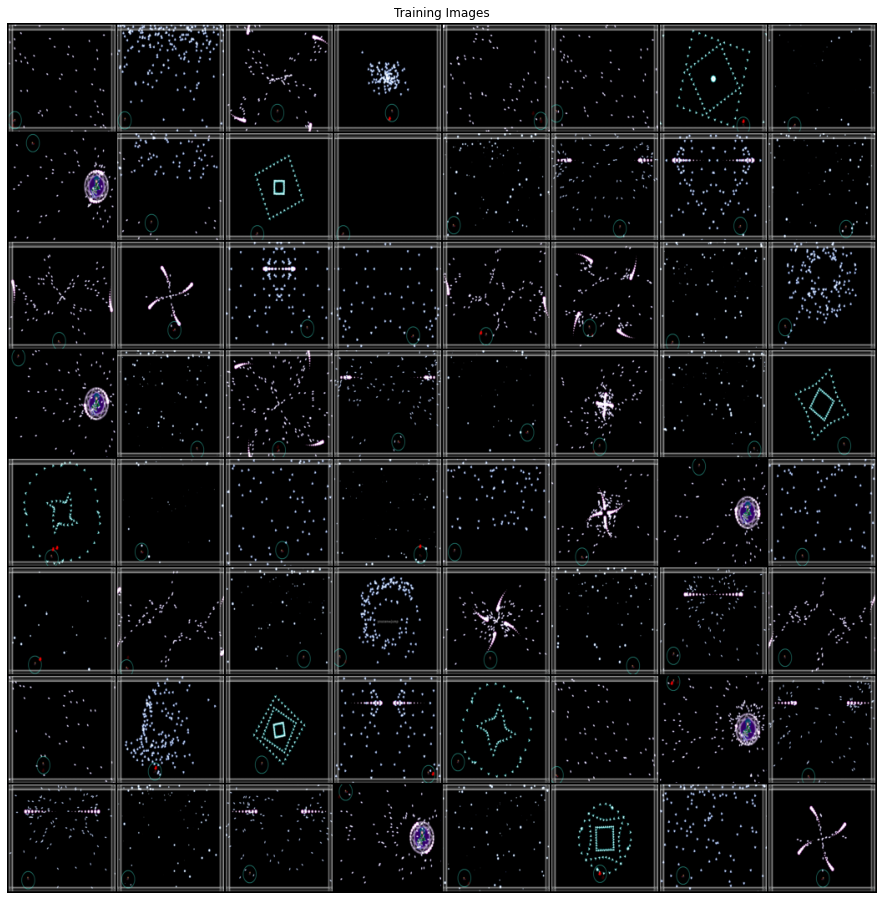

In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [8]:
next(iter(dataloader))[0].shape

torch.Size([128, 3, 128, 128])

In [9]:
class VanillaVAE(nn.Module):
    def __init__(self, in_channels=3 , latent_dim = 1000, hidden_dims = None):
        super(VanillaVAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        modules = []
        
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512, 1024]
        
        self.max_hidden = hidden_dims[len(hidden_dims)-1]
        
        # Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim
            
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        
        # Decoder
        modules = []
        
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        
        hidden_dims.reverse()
        
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i+1],
                                       kernel_size = 3,
                                       stride = 2,
                                       padding = 1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU()
                )
            )
        self.decoder = nn.Sequential(*modules)
        
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                              hidden_dims[-1],
                              kernel_size=3,
                              stride=2,
                              padding=1,
                              output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
#         print(x.shape)
        x = self.encoder(x)
#         print(x.shape)
        x = torch.flatten(x, start_dim=1)
#         print(x.shape)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return [mu, log_var]
    
    def decode(self, z):
#         print(z.shape)
        z = self.decoder_input(z)
#         print(z.shape)
        z = z.view(-1, self.max_hidden, 2, 2)
#         print(z.shape)
        z = self.decoder(z)
        z = self.final_layer(z)
        return z
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x, **kwargs):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), x, mu, log_var]
    
    def loss_f(self, *args, **kwargs):
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        
        kld_weight = kwargs['M_N']
        recons_loss = F.mse_loss(recons, input)
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim = 0)
        
        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}
    
    def sample (self, num_samples, current_device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)    
        return samples
    
    def generate(self, x, **kwargs):
        return self.forward(x)[0]


In [10]:
model = VanillaVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
from torchsummary import summary

In [12]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

In [14]:
num_epochs = 100
epoch_train_loss=[]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(dataloader):
        # 获取样本，并前向传播
        x = x.to(device)
        x_reconst,_ , mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播和优化
        loss = reconst_loss + kl_div
        epoch_train_loss.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(train_ds), reconst_loss.item(), kl_div.item()))


Epoch[1/100], Step [100/16090], Reconst Loss: 961138.6250, KL Div: 7774.7539
Epoch[2/100], Step [100/16090], Reconst Loss: 940278.1875, KL Div: 8155.9941
Epoch[3/100], Step [100/16090], Reconst Loss: 910983.1875, KL Div: 9234.6572
Epoch[4/100], Step [100/16090], Reconst Loss: 953430.1875, KL Div: 8883.8672
Epoch[5/100], Step [100/16090], Reconst Loss: 973385.2500, KL Div: 8496.4355
Epoch[6/100], Step [100/16090], Reconst Loss: 955228.0625, KL Div: 8500.0430
Epoch[7/100], Step [100/16090], Reconst Loss: 975179.0625, KL Div: 7960.0723
Epoch[8/100], Step [100/16090], Reconst Loss: 937775.4375, KL Div: 7302.0391
Epoch[9/100], Step [100/16090], Reconst Loss: 901358.8750, KL Div: 8300.4014
Epoch[10/100], Step [100/16090], Reconst Loss: 937915.6250, KL Div: 8801.0371
Epoch[11/100], Step [100/16090], Reconst Loss: 928252.5625, KL Div: 8257.0381
Epoch[12/100], Step [100/16090], Reconst Loss: 927303.5000, KL Div: 8505.4688
Epoch[13/100], Step [100/16090], Reconst Loss: 927362.0000, KL Div: 8529.

KeyboardInterrupt: 

In [37]:
os.chdir('C:/Users/user/')

In [39]:
import cv2 

ValueError: num must be 1 <= num <= 32, not 33

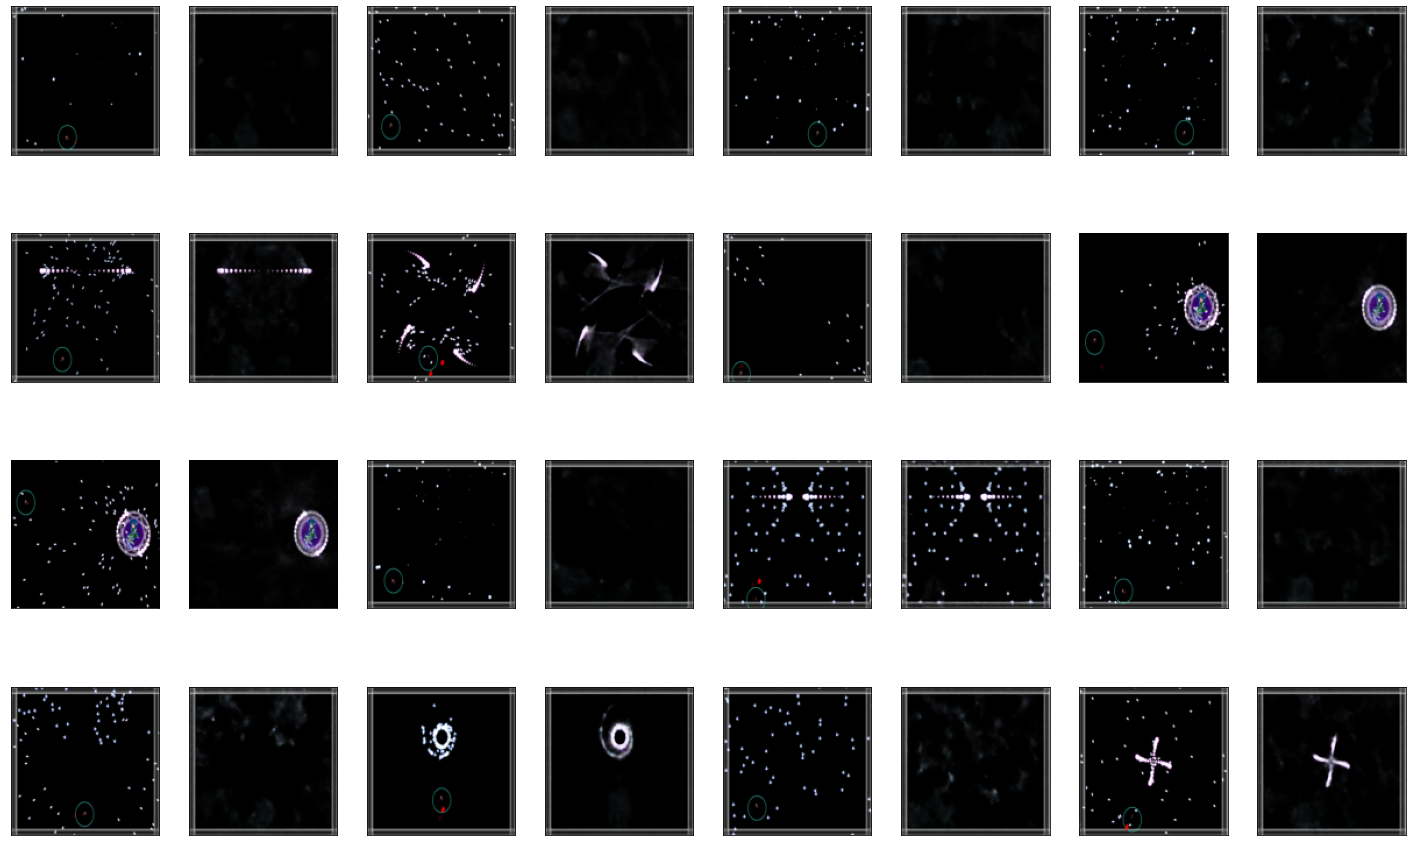

In [15]:
iter_dl = iter(dataloader)
x = next(iter_dl)
x = x[0]
recon = model.generate(x.to(device))

fig = plt.figure(figsize=(25, 16))
for i in np.arange(0,32):
    
    ax = fig.add_subplot(4, 8, i*2 + 1, xticks=[], yticks=[])
    img = x[i].numpy().transpose(1,2,0)
    plt.imshow(img)
    
    ax = fig.add_subplot(4, 8, i*2 + 2, xticks=[], yticks=[])
    img = recon[i].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(img)